In [55]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
%matplotlib inline

from utils import ChiMerge_MaxInterval_Original, CalcWOE, AssignBin, calcCut
from model_test import *

In [56]:
data = pd.read_csv('new_data/new_model_datasets.csv')
data = data.drop(['datetime'], axis=1)

# 删除后面iv较低的字段
data = data.drop(['居住地与营业厅同城', '工作地与营业厅同城', '工作地与居住地同城'], axis=1)

# 删除高相关且iv较低
data = data.drop(['idcard_applied_in_orgs', 'contacts_class1_cnt', 'user_idcard_suspicion_90', 'searched_org_cnt',
                 'user_phone_suspicion_90', 'v4', 'v14'], axis=1)

In [57]:
data.columns

Index(['customer_id', 'Good_Bad', '数据集划分', 'age', 'gender',
       'ever_bind_card_num', '手机归属本外地', '工作地城市等级', '营业厅城市等级', 'v1', 'v13',
       'v15', 'v16', 'v17', 'v18', 'v20', 'v21', 'v22', 'v23',
       'contacts_class1_blacklist_cnt', 'contacts_class2_blacklist_cnt',
       'contacts_router_cnt', 'contacts_router_ratio', 'phone_applied_org_cnt',
       'phone_gray_score', 'user_searched_history_by_orgs_90'],
      dtype='object')

In [58]:
data.corr().to_csv('corr.csv', index=False, encoding='gbk')

### 1. 粗分箱

In [42]:
def split_column(df, exclude=[]):
    bins = {}
    data = df.copy()
    for c in data.columns:
        if c not in exclude and df[c].dtype in ['int64', 'float64']:
            print('processing: %s' % c)
            c_bin = ChiMerge_MaxInterval_Original(data, col=c, target='Good_Bad', max_interval=7)
            bins[c] = c_bin
    return bins

In [43]:
cutpoints = split_column(data, exclude=['customer_id', 'Good_Bad', 'gender', '手机归属本外地', '居住地与营业厅同城'
                                       ,'工作地与营业厅同城', '工作地与居住地同城', '工作地城市等级', '营业厅城市等级', 'v1', 'v4'])

processing: age
processing: ever_bind_card_num
processing: contacts_class1_blacklist_cnt
processing: contacts_class2_blacklist_cnt
processing: contacts_router_cnt
processing: contacts_router_ratio
processing: phone_applied_org_cnt
processing: phone_gray_score
processing: user_phone_suspicion_90
processing: user_searched_history_by_orgs_90


In [44]:
cutpoints

{'age': [22, 24, 28, 36, 37, 44],
 'ever_bind_card_num': [0, 1, 3, 4, 5, 6],
 'contacts_class1_blacklist_cnt': [0.0, 1.0, 2.0, 6.0, 7.0, 13.0],
 'contacts_class2_blacklist_cnt': [0.0, 0.0, 1.0, 3.0, 7.0, 9.0],
 'contacts_router_cnt': [0.0, 0.0, 1.0, 1.0, 3.0, 6.0],
 'contacts_router_ratio': [0.0, 0.3, 0.4, 0.5, 0.6, 0.9],
 'phone_applied_org_cnt': [0.0, 2.0, 3.0, 4.0, 5.0, 6.0],
 'phone_gray_score': [6.0, 8.0, 9.0, 13.0, 33.0, 57.0],
 'user_phone_suspicion_90': [0.0, 1.0, 2.0, 3.0, 4.0, 5.0],
 'user_searched_history_by_orgs_90': [0.0, 3.0, 5.0, 8.0, 19.0, 24.0]}

In [45]:
def out_detail(data, cutpoints, target_col, cus_col):
    data = data.copy()
    woe_dfs = []  # 字段的woe及详情， dataframe
    discrete_dfs = []  # cut后的离散表
    woe_dict = {}  # 字段的woe， dict， 便于转换
    columns = [c for c in data.columns if c not in (target_col, cus_col)]
    for c in columns:
        if c in cutpoints.keys():
            df_woe_info, df_woe_cut = calcCut(data, c, target_col, cutpoints[c], 'dataframe')
            dict_woe_info, _ = calcCut(data, c, target_col, cutpoints[c], 'dict')
        else:
            df_woe_info, df_woe_cut = calcCut(data, c, target_col, None, 'dataframe')
            dict_woe_info, _ = calcCut(data, c, target_col, None, 'dict')
        df_woe_info['var_name'] = c
        woe_dfs.append(df_woe_info)
        woe_dict[c] = dict_woe_info
        # df_woe_cut 中有isBad 先删除
        df_woe_cut = df_woe_cut.drop([target_col], axis=1)  # 按行拼接
        discrete_dfs.append(df_woe_cut)  # 按列拼接
    woe_info = pd.concat(woe_dfs)
    discrete_data = pd.concat(discrete_dfs,axis=1)
    discrete_data[target_col] = data[target_col]
    discrete_data[cus_col] = data[cus_col]
    # 离散数据， woe_dataframe, woe_dict
    return discrete_data, woe_info, woe_dict

In [46]:
# 粗分箱分析
_, woe_df, _ = out_detail(data=data, cutpoints=cutpoints, target_col='Good_Bad', cus_col='customer_id')
woe_df.to_csv('DATA_WOE_COARSE.csv', index=False, encoding='gbk')

In [47]:
woe_df.head() # 用于分析

,interval,total,bad,good,bad_pct,good_pct,PctRec,WOE,ori_iv,sum_iv,var_name
0,测试集,5126,272,4854,0.192771,0.286693,0.279468,0.391735,0.036792,0.048526,数据集划分
1,训练集,13216,1139,12077,0.807229,0.713307,0.720532,-0.124933,0.011734,0.048526,数据集划分
0,"(22, 24)",601,70,531,0.049610,0.031363,0.032766,-0.478537,0.008732,0.020165,age
1,"(24, 28)",2931,269,2662,0.190645,0.157226,0.159797,-0.197958,0.006615,0.020165,age
2,"(28, 36)",7059,519,6540,0.367824,0.386274,0.384854,0.046226,0.000853,0.020165,age


### 2. 人工细分箱
根据woe_df的结果, 对卡方分箱进行合并整理,   
同时删除iv较低的特征

In [120]:
manual_cutpoints = {
 'age': [22, 28, 36, 44],
 'ever_bind_card_num': [0, 1],
 'contacts_class1_blacklist_cnt': [0.0, 1.0],
 'contacts_class2_blacklist_cnt': [0.0, 3.0, 9.0],
 'contacts_router_cnt': [0.0, 0.0, 1.0, 1.0, 3.0, 6.0],
 'contacts_router_ratio': [0.0, 0.4, 0.6],
 'phone_applied_org_cnt': [0.0, 2.0, 3.0, 4.0, 5.0, 6.0],
 'phone_gray_score': [13.0, 33.0, 57.0],
 # 'user_phone_suspicion_90': [0.0, 1.0, 2.0, 3.0, 4.0, 5.0],
 'user_searched_history_by_orgs_90': [0.0, 3.0, 5.0, 8.0, 19.0, 24.0]
}

In [121]:
# 再次检查相关性
data[list(manual_cutpoints.keys())].corr()

,age,ever_bind_card_num,contacts_class1_blacklist_cnt,contacts_class2_blacklist_cnt,contacts_router_cnt,contacts_router_ratio,phone_applied_org_cnt,phone_gray_score,user_searched_history_by_orgs_90
age,1.000000,0.071200,-0.041890,-0.060987,-0.070078,0.043746,-0.136575,0.077281,-0.088853
ever_bind_card_num,0.071200,1.000000,-0.025980,-0.064684,-0.089654,0.019383,-0.161574,0.066894,-0.085129
contacts_class1_blacklist_cnt,-0.041890,-0.025980,1.000000,0.325460,0.558377,0.126712,0.214756,-0.473253,0.077628
contacts_class2_blacklist_cnt,-0.060987,-0.064684,0.325460,1.000000,0.735118,0.013909,0.452638,-0.391601,0.258934
contacts_router_cnt,-0.070078,-0.089654,0.558377,0.735118,1.000000,-0.003514,0.572112,-0.541359,0.312858
contacts_router_ratio,0.043746,0.019383,0.126712,0.013909,-0.003514,1.000000,-0.146727,-0.019067,-0.092538
phone_applied_org_cnt,-0.136575,-0.161574,0.214756,0.452638,0.572112,-0.146727,1.000000,-0.434709,0.655712
phone_gray_score,0.077281,0.066894,-0.473253,-0.391601,-0.541359,-0.019067,-0.434709,1.000000,-0.235101
user_searched_history_by_orgs_90,-0.088853,-0.085129,0.077628,0.258934,0.312858,-0.092538,0.655712,-0.235101,1.000000


In [122]:
discrete_data, woe_df, woe_dict = out_detail(data=data, cutpoints=manual_cutpoints, target_col='Good_Bad', cus_col='customer_id')

In [123]:
# 保留此字段，仅为获得相同的实验条件
woe_df = woe_df[woe_df['var_name'] != '数据集划分']
woe_df.to_csv('DATA_DISCRETE_BINS_MANUAL.csv', index=False, encoding='gbk')

## 转换成WOE分值

In [125]:
# test
# woe_dict['quota']['WOE']['(0, 19700)']['WOE']
# discrete_data['quota_Bins'].map(lambda x: woe_dict['quota']['WOE'][x]['WOE'])

In [126]:
woe_data = pd.DataFrame()
for c in discrete_data.columns:
    if c not in ['customer_id', 'Good_Bad']:
        raw_col = '_'.join(c.split('_')[:-1])
        woe_data['%s_woe' % raw_col] = discrete_data[c].map(lambda x: woe_dict[raw_col]['WOE'][x]['WOE'])

In [127]:
# 转换好坏的概念
# 
woe_data['Good_Bad'] =  1-data['Good_Bad']
woe_data['customer_id'] = data['customer_id']
woe_data['数据集划分'] = data['数据集划分']

In [128]:
woe_data.to_csv('WOE_TRANS_DATA.csv', index=False)

In [129]:
woe_data.head()

,数据集划分_woe,age_woe,gender_woe,ever_bind_card_num_woe,手机归属本外地_woe,工作地城市等级_woe,营业厅城市等级_woe,v1_woe,v13_woe,v15_woe,...,contacts_class1_blacklist_cnt_woe,contacts_class2_blacklist_cnt_woe,contacts_router_cnt_woe,contacts_router_ratio_woe,phone_applied_org_cnt_woe,phone_gray_score_woe,user_searched_history_by_orgs_90_woe,Good_Bad,customer_id,数据集划分
0,-0.124933,-0.246285,0.386974,0.14517,0.059388,-0.072380,0.404371,-0.072869,0.225895,-0.661179,...,0.115613,-0.229831,-0.341317,0.413370,-0.628230,0.003206,0.271267,1,821448,训练集
1,-0.124933,-0.246285,0.386974,0.14517,0.059388,-0.492023,-0.461794,-0.072869,0.225895,0.318211,...,0.115613,-0.229831,-0.341317,-0.263406,-1.146442,0.003206,0.271267,1,873406,训练集
2,-0.124933,0.123376,0.386974,0.14517,0.059388,0.105069,0.039988,-0.072869,0.225895,0.318211,...,0.115613,0.439108,0.502525,-0.263406,0.528275,0.362661,0.271267,1,923212,训练集
3,-0.124933,0.005156,0.386974,0.14517,-0.211787,-0.072380,0.243127,-0.072869,-0.011400,0.318211,...,0.115613,0.439108,0.502525,-0.263406,0.528275,0.362661,0.271267,1,925219,训练集
4,-0.124933,0.046226,-0.376289,-0.08112,0.059388,-0.217972,-0.195460,-0.072869,-0.011400,0.318211,...,0.115613,-0.229831,-0.341317,0.413370,0.528275,0.003206,0.271267,1,924017,训练集


## 训练逻辑回归

In [130]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [131]:
woe_data = woe_data.drop(['数据集划分_woe'], axis=1)

x_train = woe_data[woe_data['数据集划分']=='训练集']
train_id = x_train.pop('customer_id')
y_train = x_train.pop('Good_Bad')

x_test = woe_data[woe_data['数据集划分']=='测试集']
test_id = x_test.pop('customer_id')
y_test = x_test.pop('Good_Bad')

x_train = x_train.drop(['数据集划分'], axis=1)
x_test = x_test.drop(['数据集划分'], axis=1)
# x_train, x_test, y_train, y_test = train_test_split(
#     woe_data.loc[:, woe_data.columns != 'isBad'], woe_data.loc[:, woe_data.columns == 'isBad'], test_size=0.2)

In [132]:
x_train.shape

(13216, 23)

In [134]:
lr = LogisticRegression(C=0.3, class_weight={0:10}, max_iter=10)

In [135]:
lr.fit(x_train.values, y_train.values.ravel())

LogisticRegression(C=0.3, class_weight={0: 10}, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=10,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [176]:
y_test_pred = lr.predict_proba(x_test)[:,1]
y_train_pred = lr.predict_proba(x_train)[:,1]

++++++++++++++++++++++++++++++++++
AUC:  0.8018025323751174
Recall:  0.6812993854258121
Precision:  0.21896162528216703
Accyracy:  0.7630901937046005
++++++++++++++++++++++++++++++++++


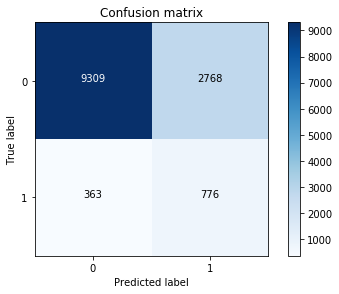

In [167]:
# 实际上这里预测的不逾期的概率， 为了是这里看起来正常， 统统用1减
# train
plot_confusion_matrix(1-y_train.values.ravel(), 1-t_train_pred, [0,1])

++++++++++++++++++++++++++++++++++
AUC:  0.7637526812331854
Recall:  0.625
Precision:  0.12022630834512023
Accyracy:  0.7374170893484199
++++++++++++++++++++++++++++++++++


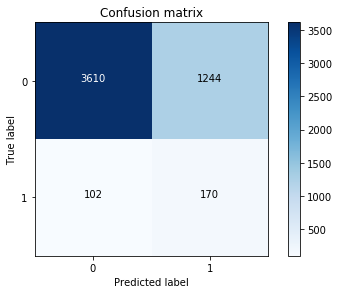

In [168]:
# 测试
plot_confusion_matrix(1-y_test.values.ravel(), 1-y_test_pred, [0,1])

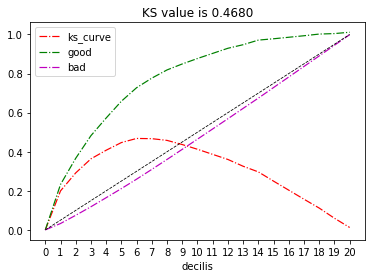

In [172]:
df_ks1,_ = ks_stats(y_train.values.ravel(), t_train_pred)

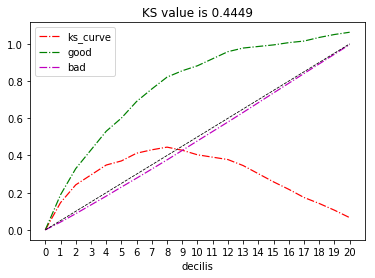

In [174]:
df_ks2,_ = ks_stats(y_test.values.ravel(), y_test_pred)

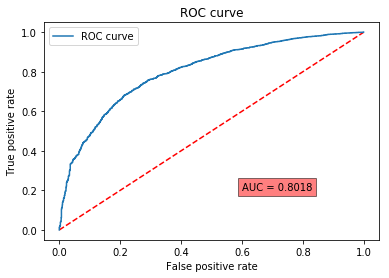

In [177]:
plot_roc_curve(y_train.values.ravel(), y_train_pred)

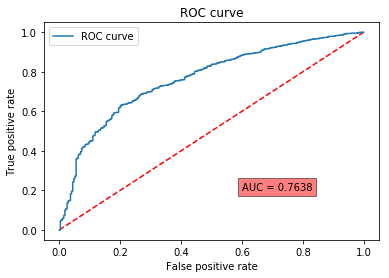

In [178]:
plot_roc_curve(y_test.values.ravel(), y_test_pred)

## 生成評分卡

In [140]:
def _score_cal(basepoints, odds, PDO):
    """
    cal alpha&beta for score formula, 
    score = alpha + beta * log(odds)
    ---------------------------------------
    Params
    basepoints: expect base points
    odds: cal by logit model
    PDO: points of double odds  
    ---------------------------------------
    Return
    alpha, beta 
    """
    beta = PDO/np.log(2)  
    alpha = basepoints - beta*np.log(odds)
    return alpha, beta

In [141]:
# 按好坏比15为600分，每高20分好坏比翻一倍算出P,Q。
basepoint = 600
PDO = 20
odds = 15
q, p = _score_cal(basepoint, odds, PDO)

In [142]:
p

28.85390081777927

In [143]:
q

521.8621880878296

In [144]:
# 截距
b = lr.intercept_[0]

In [145]:
# 系数
lr.coef_

array([[-0.29584807,  0.54280927,  2.39511878,  0.41589819,  0.42358303,
         0.38722572,  0.74138883,  1.78023522,  0.31475698,  0.0432108 ,
         0.33871977,  0.28624197,  0.70040608,  0.30585221,  0.54931767,
         0.59189128,  0.1204513 ,  0.19962774,  0.18233787,  0.14103248,
         0.64499251, -0.00860121,  0.17154403]])

In [146]:
b

0.10093549155888955

In [147]:
base_score = q + p * b

In [148]:
base_score

524.7745707502636

In [149]:
# 测试样本的B卡得分
test_score = np.dot(x_test.values, lr.coef_.ravel()) * p + q

In [150]:
test_score_df = pd.DataFrame({'customer_id': test_id, 'score':test_score, 'isBad': y_test.values.ravel()})
test_score_df.to_csv('TEST_SCORE.csv', index=False)

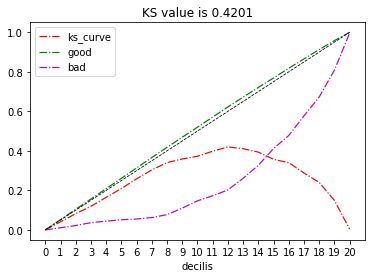

In [151]:
# 同上
df_ks,_ = ks_stats(1-y_test.values.ravel(), 1-test_score)

In [152]:
# 生成评分卡
woe_df.head()

,interval,total,bad,good,bad_pct,good_pct,PctRec,WOE,ori_iv,sum_iv,var_name
0,"(22, 28)",3532,339,3193,0.240255,0.188589,0.192564,-0.246285,0.012725,0.017458,age
1,"(28, 36)",7059,519,6540,0.367824,0.386274,0.384854,0.046226,0.000853,0.017458,age
2,"(36, 44)",4756,325,4431,0.230333,0.261709,0.259296,0.123376,0.003871,0.017458,age
3,"(44, inf)",2995,228,2767,0.161588,0.163428,0.163286,0.005156,0.000009,0.017458,age
0,1,7881,852,7029,0.603827,0.415156,0.429670,-0.376289,0.070995,0.144006,gender


In [153]:
coef_dict = dict(zip(list(x_train.columns), list(lr.coef_.ravel())))

In [154]:
coef_dict

{'age_woe': -0.29584807380907885,
 'gender_woe': 0.5428092684031416,
 'ever_bind_card_num_woe': 2.3951187762258535,
 '手机归属本外地_woe': 0.41589818858344196,
 '工作地城市等级_woe': 0.42358302922187124,
 '营业厅城市等级_woe': 0.3872257212409813,
 'v1_woe': 0.7413888293610755,
 'v13_woe': 1.7802352196450792,
 'v15_woe': 0.3147569762495594,
 'v16_woe': 0.04321079623778148,
 'v17_woe': 0.3387197728219504,
 'v18_woe': 0.28624197231549026,
 'v20_woe': 0.7004060817998133,
 'v21_woe': 0.3058522076305581,
 'v22_woe': 0.5493176722238814,
 'v23_woe': 0.5918912849789766,
 'contacts_class1_blacklist_cnt_woe': 0.12045129649118969,
 'contacts_class2_blacklist_cnt_woe': 0.19962773684004442,
 'contacts_router_cnt_woe': 0.1823378676997497,
 'contacts_router_ratio_woe': 0.1410324798607833,
 'phone_applied_org_cnt_woe': 0.6449925090905219,
 'phone_gray_score_woe': -0.008601211588235633,
 'user_searched_history_by_orgs_90_woe': 0.1715440296915046}

In [155]:
woe_df['score'] = woe_df.apply(lambda row: row['WOE'] * p * coef_dict['%s_woe' % row['var_name']], axis=1)

In [160]:
woe_df.to_csv('SCORE.csv', index=False, encoding='gbk')

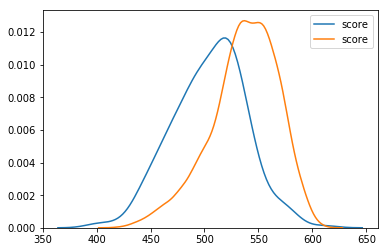

In [159]:
sns.kdeplot(test_score_df[test_score_df['isBad']==0]['score'])
sns.kdeplot(test_score_df[test_score_df['isBad']==1]['score'])